In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
%cd /content/drive/MyDrive/NEU_DET_SurfaceAnomalyDetection

/content/drive/MyDrive/NEU_DET_SurfaceAnomalyDetection


In [ ]:
! pip install pennylane

## Run if you plan to use GPU

In [ ]:
!pip install pennylane-lightning[gpu]
!pip install wheel cuquantum

#Load and Preprocess Data

In [ ]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import cv2
import albumentations.augmentations.functional as F
from Utilities.Extract_masks import create_filepaths
from PIL import Image, ImageOps
from tqdm import tqdm
import shutil
import cv2
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from torchvision import transforms

In [ ]:
image_folder = 'IMAGES'
annot_folder = 'ANNOTATIONS'
noDefect_folder = 'NO_DEFECT'
resizedImage_folder = 'ReIMAGES'
resizedNoDefectImage_folder = 'ReNO_DEFECT'
results_folder = "RESULTS"

In [ ]:
x_dim, y_dim = (200, 200)

## Test accuracy function

In [ ]:
def test_acc(model, test_loader, device):
    model.eval()
    correct, total = 0, 0
    with torch.no_grad():
        for images, labels in test_loader:
            images = images.to(device)
            outputs = model(images) #-1x2
            predictions = np.argmax(outputs.detach().cpu().numpy(), axis = 1)
            correct += np.sum(np.logical_not(np.logical_xor(predictions, labels.numpy())))
            total += len(predictions)

    accuracy = correct / total
    return accuracy

## Do not run the following 7 cells a second time unless you change the value of (x_dim, y_dim)

In [ ]:
df = create_filepaths(annot_folder)

In [ ]:
selected_anomalies = ["rolled-in_scale", "patches", "inclusion", "scratches"]

In [ ]:
def test_acc(model, test_loader):
    model.eval()
    correct, total = 0, 0
    with torch.no_grad():
        for images, labels in test_loader:
            images = images.to(device)
            outputs = model(images) #-1x2
            predictions = np.argmax(outputs.detach().cpu().numpy(), axis = 1)
            correct += np.sum(np.logical_not(np.logical_xor(predictions, labels.numpy())))
            total += len(predictions)

    accuracy = correct / total
    return accuracy

In [ ]:
def load_preprocess_defective_images(df, image_folder, selected_anomalies, resizedImage_folder):
    subset = []
    shutil.rmtree(resizedImage_folder)
    os.mkdir(resizedImage_folder)
    for label in selected_anomalies:
        ls = df[df["Number_of_Defects"] == 1][df[label] == 1]["Name"].to_list()
        subset+=ls
    for fname in tqdm(subset):
        fpath = os.path.join(image_folder, (fname+".jpg"))
        image = Image.open(fpath)
        image = image.resize((x_dim, y_dim))
        image = ImageOps.grayscale(image)
        image.save(os.path.join(resizedImage_folder, (fname+".jpg")))

In [ ]:
load_preprocess_defective_images(df, image_folder, selected_anomalies, resizedImage_folder)

<ipython-input-9-b617c8ed65f0>:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  ls = df[df["Number_of_Defects"] == 1][df[label] == 1]["Name"].to_list()
100%|██████████| 1103/1103 [06:21<00:00,  2.89it/s]


In [ ]:
def load_preprocess_no_defective_images(noDefect_folder, resizedNoDefectImage_folder):
    if(os.path.exists(resizedNoDefectImage_folder)):
        shutil.rmtree(resizedNoDefectImage_folder)
    os.mkdir(resizedNoDefectImage_folder)
    for fpath in tqdm(os.listdir(noDefect_folder)):
        image = Image.open(os.path.join(noDefect_folder, fpath))
        image = image.resize((x_dim, y_dim))
        image = ImageOps.grayscale(image)
        image.save(os.path.join(resizedNoDefectImage_folder, fpath))

In [ ]:
load_preprocess_no_defective_images(noDefect_folder, resizedNoDefectImage_folder)

100%|██████████| 1927/1927 [00:52<00:00, 37.01it/s] 


# Prepare Dataset

## Resize features and make labels

In [ ]:
import os
import cv2
import numpy as np
selected_anomalies_labels = ["rolled-in","patches", "inclusion", "scratches"]
labels_ano = []
X_ano = []
for fname in os.listdir(resizedImage_folder):

    for i in range(len(selected_anomalies_labels)):
        if(fname.split('_')[0] == selected_anomalies_labels[i]):
            labels_ano.append(i+1)
            break
    fpath = os.path.join(resizedImage_folder, fname)
    im = cv2.imread(fpath, 0) # gray scale read
    im = im.reshape(1, im.shape[0], im.shape[1])
    X_ano.append(im)
X_ano = np.array(X_ano)
labels_ano = np.array(labels_ano)

In [ ]:
X_ano.shape, labels_ano.shape

((1103, 1, 200, 200), (1103,))

In [ ]:
X_norm = []
labels_norm = np.zeros(len(os.listdir(resizedNoDefectImage_folder)))
for fname in os.listdir(resizedNoDefectImage_folder):
    fpath = os.path.join(resizedNoDefectImage_folder, fname)
    im = cv2.imread(fpath, 0) # gray scale read
    im = im.reshape(1, im.shape[0], im.shape[1])
    X_norm.append(im)
X_norm = np.array(X_norm)

In [ ]:
X_norm.shape, labels_norm.shape

((1927, 1, 200, 200), (1927,))

In [ ]:
random_idx = np.random.randint(low=0, high=X_norm.shape[0], size = (X_ano.shape[0]))
X_norm = X_norm[random_idx]
labels_norm = labels_norm[random_idx]
X_norm.shape

(1103, 1, 200, 200)

# Binary classification

In [ ]:
import numpy as np
X = np.concatenate((X_norm, X_ano), axis = 0)
Y_poly = np.concatenate((labels_norm, labels_ano), axis = 0)
Y_bin = Y_poly
Y_bin [Y_bin > 0] = 1
X.shape, Y_bin.shape

((2206, 1, 200, 200), (2206,))

In [ ]:
#Standardize
X = X/255.0

In [ ]:
# Train Test Split
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, Y_bin, test_size=0.25, random_state = 42)

In [ ]:
y_train = np.array([np.eye(2)[int(i),:] for i in y_train])

In [ ]:
X_train.shape

(1654, 1, 200, 200)

## Testing Models

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from torchvision import transforms

# Assuming you have torch.cuda.is_available() to check for GPU availability
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Convert your NumPy arrays to PyTorch tensors
X_train_tensor = torch.Tensor(X_train).view(-1, 1, 200, 200)
y_train_tensor = torch.FloatTensor(y_train)  # Convert to FloatTensor for binary classification
X_test_tensor = torch.Tensor(X_test).view(-1, 1, 200, 200)
y_test_tensor = torch.FloatTensor(y_test)  # Convert to FloatTensor for binary classification

# Create TensorDatasets
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)

# Create DataLoader
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

# Define the CNN model for binary classification with kernel size 8
class CNNBinary(nn.Module):
    def __init__(self):
        super(CNNBinary, self).__init__()
        self.name = "ClassicalModel1"
        # Input shape: -1, 1, 200, 200
        self.conv1 = nn.Conv2d(1, 32, kernel_size=4, stride = 2) # -1, 32, 99, 99
        self.maxpool1 = nn.MaxPool2d(kernel_size=4, stride=2) # -1, 32, 48, 48

        self.conv2 = nn.Conv2d(32, 64, kernel_size=8, stride = 2) # -1, 64, 21, 21
        self.maxpool2 = nn.MaxPool2d(kernel_size=2, stride=2)     # -1, 64, 10, 10

        self.conv3 = nn.Conv2d(64, 128, kernel_size=4, stride = 2)            # -1, 128, 4, 4

        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(128 * 4 * 4, 128)  # Adjusted based on the new feature dimensions
        self.dropout1 = nn.Dropout(p=0.5)
        self.fc2 = nn.Linear(128, 64)  # Output 2 value for binary classification
        self.dropout2 = nn.Dropout(p=0.25)
        self.fc3 = nn.Linear(64, 16)
        self.fc4 = nn.Linear(16,2)

    def forward(self, x):
        x = self.maxpool1(torch.relu(self.conv1(x)))
        x = self.maxpool2(torch.relu(self.conv2(x)))
        x = torch.relu(self.conv3(x))

        x = self.flatten(x)
        x = self.dropout1(torch.relu(self.fc1(x)))
        x = self.dropout2(torch.relu(self.fc2(x)))

        x = torch.relu(self.fc3(x))

        x = torch.log_softmax(self.fc4(x), dim=1)
        return x

# Initialize the model, loss function, and optimizer
model = CNNBinary().to(device)
criterion = nn.CrossEntropyLoss()  # Binary Cross Entropy with Logits
optimizer = optim.Adam(model.parameters(), lr=0.001)

'''
# Train the model
num_epochs = 150
for epoch in range(num_epochs):
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)  # Flatten the output for binary classification
        loss.backward()
        optimizer.step()

    print(f'Epoch [{epoch + 1}/{num_epochs}], Loss: {loss.item():.4f}')
'''

"\n# Train the model\nnum_epochs = 150\nfor epoch in range(num_epochs):\n    for images, labels in train_loader:\n        images, labels = images.to(device), labels.to(device)\n        optimizer.zero_grad()\n        outputs = model(images)\n        loss = criterion(outputs, labels)  # Flatten the output for binary classification\n        loss.backward()\n        optimizer.step()\n\n    print(f'Epoch [{epoch + 1}/{num_epochs}], Loss: {loss.item():.4f}')\n"

In [ ]:
# Train the model
num_epochs = 10
for epoch in range(num_epochs):
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)  # Flatten the output for binary classification
        loss.backward()
        optimizer.step()

    print(f'Epoch [{epoch + 1}/{num_epochs}], Loss: {loss.item():.4f}')

Epoch [1/10], Loss: 0.0007
Epoch [2/10], Loss: 0.0007
Epoch [3/10], Loss: 0.0003
Epoch [4/10], Loss: 0.0001
Epoch [5/10], Loss: 0.0005
Epoch [6/10], Loss: 0.0005
Epoch [7/10], Loss: 0.0004
Epoch [8/10], Loss: 0.0004
Epoch [9/10], Loss: 0.0015
Epoch [10/10], Loss: 0.0005


In [ ]:
# Evaluate the model on the test set
model.eval()
correct, total = 0, 0
with torch.no_grad():
    for images, labels in test_loader:
        images = images.to(device)
        outputs = model(images) #-1x2
        predictions = np.argmax(outputs.detach().cpu().numpy(), axis = 1)
        correct += np.sum(np.logical_not(np.logical_xor(predictions, labels.numpy())))
        total += len(predictions)

accuracy = correct / total
print(f'Test accuracy: {accuracy:.4f}')

Test accuracy: 0.9239


## HQNN

In [ ]:
!pip install pennylane

In [ ]:
!pip install pennylane-lightning[gpu]
!pip install wheel cuquantum

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import pennylane as qml
from pennylane import numpy as np
from tqdm import tqdm

# Set Up the Environment
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Data Preparation (Assuming data is pre-loaded)
features = X_train
labels = y_train

# Convert data to PyTorch tensors and move them to the device (GPU if available)
features = torch.tensor(features, dtype=torch.float32).to(device)
labels = torch.tensor(labels, dtype=torch.float32).to(device)

# Create datasets and dataloaders
batch_size = 64  # Define your batch size
train_dataset = TensorDataset(features, labels)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

# Create the Quantum Circuit (Same as before)
# Step 3: Create the Quantum Circuit

n_qubits = 5
n_layers = 4

# Initialize a PennyLane device with the default.qubit simulator
dev = qml.device("lightning.gpu", wires=n_qubits) if torch.cuda.is_available() else qml.device("default.qubit", wires=n_qubits)
#dev = qml.device("default.qubit", wires=n_qubits)

@qml.qnode(dev, interface="torch")
def quantum_circuit(inputs, weights):
    # Hadamard Layer
    #qml.Hadamard(wires=range(n_qubits))
    # Embedding layer
    qml.AngleEmbedding(inputs, wires=range(n_qubits))

    # Variational layer
    for _ in range(n_layers):
        qml.StronglyEntanglingLayers(weights, wires=range(n_qubits))

    return [qml.expval(qml.PauliZ(wires=i)) for i in range(n_qubits)]

# Weight shapes
weight_shapes = {"weights": (n_layers, n_qubits, 3)}

# Quantum layer
qlayer = qml.qnn.TorchLayer(quantum_circuit, weight_shapes)

# Create the Hybrid Model (Same as before)
class HybridNN(nn.Module):
    def __init__(self):
        super(HybridNN, self).__init__()

#######################################################################################################
        # Input shape: -1, 1, 200, 200
        self.conv1 = nn.Conv2d(1, 32, kernel_size=4, stride = 2) # -1, 32, 99, 99
        self.maxpool1 = nn.MaxPool2d(kernel_size=4, stride=2) # -1, 32, 48, 48

        self.conv2 = nn.Conv2d(32, 64, kernel_size=8, stride = 2) # -1, 64, 21, 21
        self.maxpool2 = nn.MaxPool2d(kernel_size=2, stride=2)     # -1, 64, 10, 10

        self.conv3 = nn.Conv2d(64, 128, kernel_size=4, stride = 2)            # -1, 128, 4, 4

        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(128 * 4 * 4, 128)  # Adjusted based on the new feature dimensions
        self.dropout1 = nn.Dropout(p=0.5)
        self.fc2 = nn.Linear(128, 64)  # Output 2 value for binary classification
        self.dropout2 = nn.Dropout(p=0.25)
        self.fc3 = nn.Linear(64, 5)


        self.q_layer = qlayer

        self.fc4 = nn.Linear(5,2)
        self.to(device)  # Move the entire model to the device (GPU if available)

    def forward(self, x):

        x = self.maxpool1(torch.relu(self.conv1(x)))
        x = self.maxpool2(torch.relu(self.conv2(x)))
        x = torch.relu(self.conv3(x))

        x = self.flatten(x)
        x = self.dropout1(torch.relu(self.fc1(x)))
        x = self.dropout2(torch.relu(self.fc2(x)))
        x = torch.relu(self.fc3(x))

        #x = x.cpu()  # Move x to CPU for quantum layer
        x = self.q_layer(x)
        #x = x.to(device)

        x = torch.log_softmax(self.fc4(x), dim=1)
        return x
'''
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = x.cpu()  # Move x to CPU for quantum layer
        x = self.q_layer(x)
        x = x.to(device)  # Move x back to the device (GPU if available) for final layer
        x = self.fc3(x)
        return torch.log_softmax(x, dim=1)
'''

# Model, Loss, and Optimizer
model = HybridNN().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
#qml.draw_mpl(quantum_circuit)
# Training loop
epochs = 100
for epoch in range(epochs):
    total_loss = 0
    for batch_idx, (feature, label) in tqdm(enumerate(train_loader)):
        feature, label = feature.to(device), label.to(device)
        optimizer.zero_grad()
        output = model(feature)
        loss = criterion(output, label)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    if(epoch%10 == 0):
        avg_loss = total_loss / len(train_loader.dataset)
        print(f"Epoch {epoch+1}/{epochs}, Loss: {avg_loss:.4f}")
        print(f"Test Accuracy: {test_acc(model, test_loader):.4f}")

In [ ]:
epochs = 10
for epoch in range(epochs):
    total_loss = 0
    for batch_idx, (feature, label) in tqdm(enumerate(train_loader)):
        feature, label = feature.to(device), label.to(device)
        optimizer.zero_grad()
        output = model(feature)
        loss = criterion(output, label)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()

    avg_loss = total_loss / len(train_loader.dataset)
    print(f"Epoch {epoch+1}/{epochs}, Loss: {avg_loss:.4f}")

In [ ]:
test_acc(model, test_loader)

# Get Results

# Test and get results from Classical Models

In [ ]:
from Models import ClassicalModel1, ClassicalModel2, ClassicalModel3, ClassicalModel4

In [ ]:
classical_models = [ClassicalModel1, ClassicalModel2, ClassicalModel3, ClassicalModel4]

def trainModels(models, train_loader, test_loader, criterion, epochs):
    results_dict = {}
    for M in models:
        for i in tqdm(range(5)):
            seed = torch.random.seed()
            torch.manual_seed(seed)
            model = M()
            mode_name = model.name + '_' + str(seed)
            model_parameters = filter(lambda p: p.requires_grad, model.parameters())
            params_number = sum([np.prod(p.size()) for p in model_parameters])
            results_dict[mode_name] = {"loss":[], "test_acc":[], "seed": seed, "params_number": params_number}
            model.to(device)
            optimizer = optim.Adam(model.parameters(), lr=0.001)
            print(f"Training {mode_name}")
            for epoch in range(epochs):
                total_loss = 0
                avg_loss = 0
                for batch_idx, (feature, label) in tqdm(enumerate(train_loader)):
                    feature, label = feature.to(device), label.to(device)
                    optimizer.zero_grad()
                    output = model(feature)
                    loss = criterion(output, label)
                    loss.backward()
                    optimizer.step()
                    total_loss += loss.item()

                if(epoch%10 == 0):
                    avg_loss = total_loss / len(train_loader.dataset)
                    results_dict[mode_name]["loss"].append(avg_loss)
                    test_accuracy = test_acc(model, test_loader)
                    results_dict[mode_name]["test_acc"].append(test_accuracy)
    return results_dict

In [ ]:
#device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Convert your NumPy arrays to PyTorch tensors
X_train_tensor = torch.Tensor(X_train).view(-1, 1, x_dim, y_dim)
y_train_tensor = torch.FloatTensor(y_train)  # Convert to FloatTensor for binary classification
X_test_tensor = torch.Tensor(X_test).view(-1, 1, x_dim, y_dim)
y_test_tensor = torch.FloatTensor(y_test)  # Convert to FloatTensor for binary classification

# Create TensorDatasets
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)

# Create DataLoader
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

# Loss function
criterion = nn.CrossEntropyLoss()


In [ ]:
results = trainModels(classical_models, train_loader, test_loader, criterion, epochs=150)

In [ ]:
import json
#file_path = os.path.join(results_folder, 'test_classical_results_dictionary.json')
file_path = 'test_classical_results_dictionary.pkl'
import pickle
'''
with open(file_path, 'wb') as f:
    pickle.dump(results, f)
'''
with open(file_path, 'rb') as f:
    loaded_dict = pickle.load(f)

In [ ]:
import matplotlib.pyplot as plt
plt.figure(figsize = (10,8), dpi=100)
for model in results.keys():

    plt.plot(loaded_dict[model]["test_acc"], label = model)
plt.legend()
plt.show()

# Test Hybrid models

In [ ]:
import pickle
def saveResults(results, file_path):
    with open(file_path, 'wb') as f:
        pickle.dump(results, f)
def saveModels(models, root_dir):
    for model in models.keys():
        torch.save(models[model].state_dict(), os.path.join(root_dir, model))

In [ ]:
best_seed = 5132595725441423083

In [ ]:
def trainHybridModel(models, train_loader, test_loader, criterion, epochs):
    results_dict = {}
    model_list = {}
    for M in models:
        for i in range(5):
            seed = torch.random.seed()
            torch.manual_seed(seed)
            model = M()
            model_name = model.name + '_' + str(seed)
            model_parameters = filter(lambda p: p.requires_grad, model.parameters())
            params_number = sum([np.prod(p.size()) for p in model_parameters])
            results_dict[model_name] = {"loss":[], "test_acc":[], "seed": seed, "params_number": params_number}
            model_list[model_name] = model
            model.to(device)
            optimizer = optim.Adam(model.parameters(), lr=0.001)
            print(f"Training {model_name}")
            for epoch in tqdm(range(epochs)):
                total_loss = 0
                avg_loss = 0
                for batch_idx, (feature, label) in enumerate(train_loader):
                    feature, label = feature.to(device), label.to(device)
                    optimizer.zero_grad()
                    output = model(feature)
                    loss = criterion(output, label)
                    loss.backward()
                    optimizer.step()
                    total_loss += loss.item()

                if(epoch%5 == 0):
                    avg_loss = total_loss / len(train_loader.dataset)
                    results_dict[model_name]["loss"].append(avg_loss)
                    test_accuracy = test_acc(model, test_loader)
                    results_dict[model_name]["test_acc"].append(test_accuracy)
    return results_dict, model_list

In [ ]:
#device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Convert your NumPy arrays to PyTorch tensors
X_train_tensor = torch.Tensor(X_train).view(-1, 1, x_dim, y_dim)
y_train_tensor = torch.FloatTensor(y_train)  # Convert to FloatTensor for binary classification
X_test_tensor = torch.Tensor(X_test).view(-1, 1, x_dim, y_dim)
y_test_tensor = torch.FloatTensor(y_test)  # Convert to FloatTensor for binary classification

# Create TensorDatasets
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)

# Create DataLoader
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

# Loss function
criterion = nn.CrossEntropyLoss()

In [ ]:
from Models import HybridModel1
hybrid_models = [HybridModel1]
results, models = trainHybridModel(hybrid_models, train_loader, test_loader, criterion, epochs=150)

results_file_path = 'RESULTS/test_hybrid_results_dictionary.pkl'

saveResults(results, results_file_path)
saveModels(models, 'RESULTS/')

Training HybridModel1_1902807487404998005


100%|██████████| 150/150 [18:26<00:00,  7.37s/it]


Training HybridModel1_15264327359038634347


100%|██████████| 150/150 [18:45<00:00,  7.50s/it]


Training HybridModel1_13196567083587539558


100%|██████████| 150/150 [18:46<00:00,  7.51s/it]


Training HybridModel1_13936601866908921052


100%|██████████| 150/150 [18:31<00:00,  7.41s/it]


Training HybridModel1_15846211979213876230


100%|██████████| 150/150 [18:21<00:00,  7.34s/it]


In [ ]:
import pickle
results_file_path = 'RESULTS/test_hybrid_results_dictionary.pkl'
with open(results_file_path, 'rb') as f:
    loaded_dict = pickle.load(f)

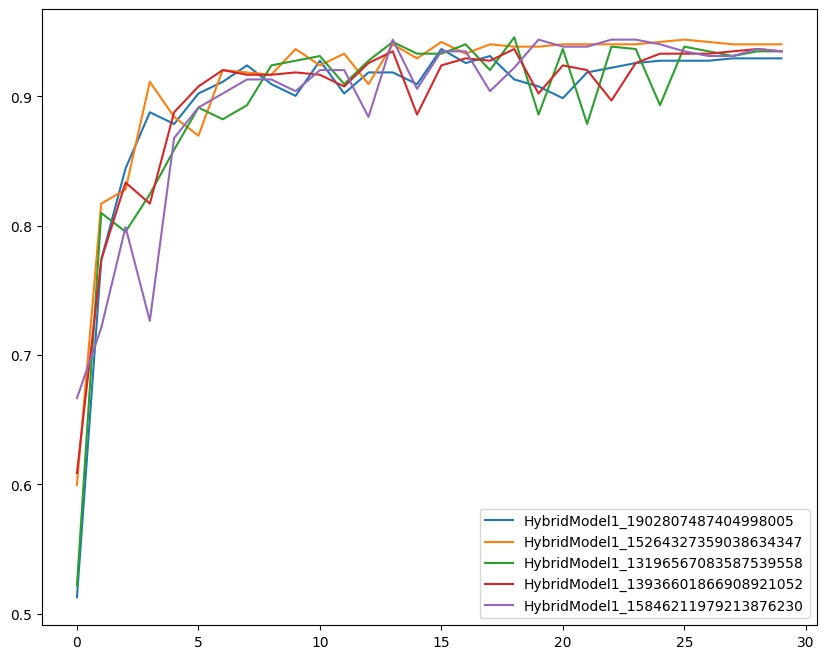

In [ ]:
import matplotlib.pyplot as plt
plt.figure(figsize = (10,8), dpi=100)
for model in loaded_dict.keys():
    plt.plot(loaded_dict[model]["test_acc"], label = model)
plt.legend()
plt.show()

In [ ]:
max(loaded_dict['HybridModel1_15264327359038634347']['test_acc'])

0.9438405797101449

# Building a transfer learning based Model

## Train the best classical model

In [ ]:
def trainModel(model, train_loader, test_loader, criterion, epochs, seed=None, class_instance = 0):
    '''
        # function to run any model on the given data
        # If there is a given seed that means, we have the seed best suited for the input model
        # class_instance = 0 implies that the model is not an object, in theat case instantiate this model
    '''
    if(seed == None):
        seed = torch.random.seed()
    torch.manual_seed(seed)
    results_dict = {}
    if(class_instance == 0):
        model = model()
    model_name = model.name + '_' + str(seed)
    model_parameters = filter(lambda p: p.requires_grad, model.parameters())
    params_number = sum([np.prod(p.size()) for p in model_parameters])
    results_dict[model_name] = {"loss":[], "test_acc":[], "seed": seed, "params_number": params_number}
    #device
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)
    optimizer = optim.Adam(model.parameters(), lr=0.001)
    print(f"Training {model_name}")
    for epoch in tqdm(range(epochs)):
        total_loss = 0
        avg_loss = 0
        for batch_idx, (feature, label) in enumerate(train_loader):
            feature, label = feature.to(device), label.to(device)
            optimizer.zero_grad()
            output = model(feature)
            loss = criterion(output, label)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()
        avg_loss = total_loss / len(train_loader.dataset)
        results_dict[model_name]["loss"].append(avg_loss)
        test_accuracy = test_acc(model, test_loader, device)
        results_dict[model_name]["test_acc"].append(test_accuracy)
    return results_dict, model

### Define your test loader and train loader functions, and loss function

In [ ]:
criterion = nn.CrossEntropyLoss()

# Convert your NumPy arrays to PyTorch tensors
X_train_tensor = torch.Tensor(X_train).view(-1, 1, x_dim, y_dim)
y_train_tensor = torch.FloatTensor(y_train)  # Convert to FloatTensor for binary classification
X_test_tensor = torch.Tensor(X_test).view(-1, 1, x_dim, y_dim)
y_test_tensor = torch.FloatTensor(y_test)  # Convert to FloatTensor for binary classification

# Create TensorDatasets
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)

# Create DataLoader
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

# Loss function
criterion = nn.CrossEntropyLoss()

### Train the classical model

In [ ]:
from Models import ClassicalModel1, ClassicalModel2, ClassicalModel3, ClassicalModel4
best_seed = 5132595725441423083
results, model = trainModel(ClassicalModel2, train_loader, test_loader, criterion, epochs=150, seed=best_seed)
torch.save(model, 'RESULTS/ClassicalModel2_5132595725441423083.pt')

## Import the best classical model trained

In [ ]:
classicalModel2_trained = torch.load('RESULTS/ClassicalModel2_5132595725441423083.pt', map_location=torch.device('cpu'))

In [ ]:
print(classicalModel2_trained)

## Build the dressed quantum net

In [ ]:
from Models import Q_linear

class DressedQuantumNet(nn.Module):
    def __init__(self):
        super().__init__()
        self.pre_net = nn.Linear(16, 5)
        self.qlayer = Q_linear(in_features=5, n_layers=3)
        self.post_net = nn.Linear(5, 2)

    def forward(self, x):
        x = torch.tanh(self.pre_net(x)) * np.pi / 2.0
        x = torch.relu(self.qlayer(x))
        x = self.post_net(x)
        return x

## Instantiate the transfer learning based model

In [ ]:
classical_model_path = 'RESULTS/ClassicalModel2_5132595725441423083.pt'
def build_hybrid_model(classical_model_path, DressedQuantumNet, device):
    # Best performing Classical Model
    classicalModel2_trained = torch.load(classical_model_path, map_location = device)

    hybridModel = classicalModel2_trained
    hybridModel.name = 'HybridModel1_transferLearning_based'

    for param in hybridModel.parameters():
        param.requires_grad = False
    hybridModel.fc4 = DressedQuantumNet()
    return hybridModel

### Train the hybird transfer learning based model

In [ ]:
results, model = trainModel(hybridModel, train_loader, test_loader, criterion = criterion, epochs = 100, class_instance=1)

Training HybridModel1_transferLearning_based_3099580363048419395


100%|██████████| 100/100 [46:35<00:00, 27.96s/it]


In [ ]:
results.keys()

dict_keys(['HybridModel1_transferLearning_based_3099580363048419395'])

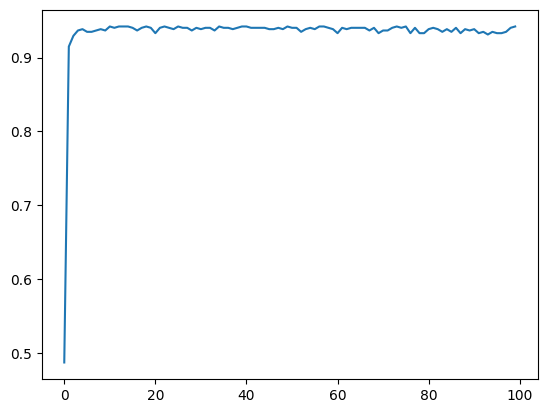

In [ ]:
plt.plot(results['HybridModel1_transferLearning_based_3099580363048419395']['test_acc'])  # accuracy

In [ ]:
max(results['HybridModel1_transferLearning_based_3099580363048419395']['test_acc'])

0.9420289855072463

In [ ]:
Y_bin.shape

(2206,)

In [ ]:
x = np.array([0,0,1,1,1])

np.array(np.eye(2)[x])

array([[1., 0.],
       [1., 0.],
       [0., 1.],
       [0., 1.],
       [0., 1.]])

## K-fold cross validation

In [ ]:
import numpy as np
import torch
from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import KFold
from sklearn.metrics import precision_score, recall_score, f1_score

# Best classical model
classical_model_path = 'RESULTS/ClassicalModel2_5132595725441423083.pt'

# Model to test
#best_hybrid_model = hybridModel
criterion = torch.nn.CrossEntropyLoss()  # For classification tasks, adjust accordingly
num_epochs = 40

# Convert your features and labels to PyTorch tensors
# X is X
y = Y_bin


# Define KFold cross validator
kf = KFold(n_splits=6, shuffle=True, random_state=42)
results_dict = {}
models = {}

# Define a device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Loop through each fold
for fold, (train_idx, val_idx) in enumerate(kf.split(X)):
    print(f"Fold {fold+1}")

    # Instantiating the hybrid model
    model = build_hybrid_model(classical_model_path, DressedQuantumNet, device)
    model_name = f"HybridModel1_transferLearning_based_{fold+1}"
    models[model_name] = None
    results_dict[model_name] = {"loss": [], "test_acc": [], "precision": 0, "recall": 0, "F1_score": 0}
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

    # Split the data into training and validation sets for this fold
    X_train, X_val = torch.tensor(X[train_idx], dtype=torch.float32), torch.tensor(X[val_idx], dtype=torch.float32)
    y_train, y_val = y[train_idx], torch.tensor(y[val_idx], dtype=torch.float32)
    y_train = torch.tensor(np.array(np.eye(2)[y_train.astype(int)]), dtype=torch.float32)


    # Convert to PyTorch DataLoader
    train_loader = DataLoader(TensorDataset(X_train, y_train), batch_size=64, shuffle=True)
    val_loader = DataLoader(TensorDataset(X_val, y_val), batch_size=64)

    # Training loop for this fold
    for epoch in tqdm(range(num_epochs)):  # num_epochs is a variable you should define
        total_loss = 0
        avg_loss = 0
        for batch_idx, (feature, label) in enumerate(train_loader):
            feature, label = feature.to(device), label.to(device)
            optimizer.zero_grad()
            output = model(feature)
            loss = criterion(output, label)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()
        avg_loss = total_loss / len(train_loader.dataset)
        results_dict[model_name]["loss"].append(avg_loss)
        test_accuracy = test_acc(model, val_loader, device)
        results_dict[model_name]["test_acc"].append(test_accuracy)
    # Training done
    # Calculate the precision, recall and f1 score of this model
    true_labels = y_val.numpy()
    predictions = model(X_val)
    predicted_labels = np.argmax(predictions.detach().cpu().numpy(), axis = 1)
    results_dict[model_name]["precision"] = precision_score(true_labels, predicted_labels, average='macro')  # Use 'micro', 'macro', 'weighted', or 'samples' for multi-class
    results_dict[model_name]["recall"] = recall_score(true_labels, predicted_labels, average='macro')
    results_dict[model_name]["F1_score"] = f1_score(true_labels, predicted_labels, average='macro')
    #torch.save(model, f"RESULTS/HybridModels_k_fold_cross_val/{model_name}.pt")
    models[model_name] = model

# Save the results_dict
results_file_path = 'RESULTS/HybridModels_k_fold_cross_val_1/hybridModel_transfer_learning_k-fold_cross_val_results_dictionary.pkl'
saveResults(results_dict, results_file_path)

Fold 1


100%|██████████| 40/40 [19:16<00:00, 28.92s/it]


Fold 2


100%|██████████| 40/40 [18:45<00:00, 28.13s/it]


Fold 3


100%|██████████| 40/40 [19:12<00:00, 28.82s/it]


Fold 4


100%|██████████| 40/40 [18:50<00:00, 28.25s/it]


Fold 5


100%|██████████| 40/40 [18:57<00:00, 28.44s/it]


Fold 6


100%|██████████| 40/40 [18:56<00:00, 28.41s/it]


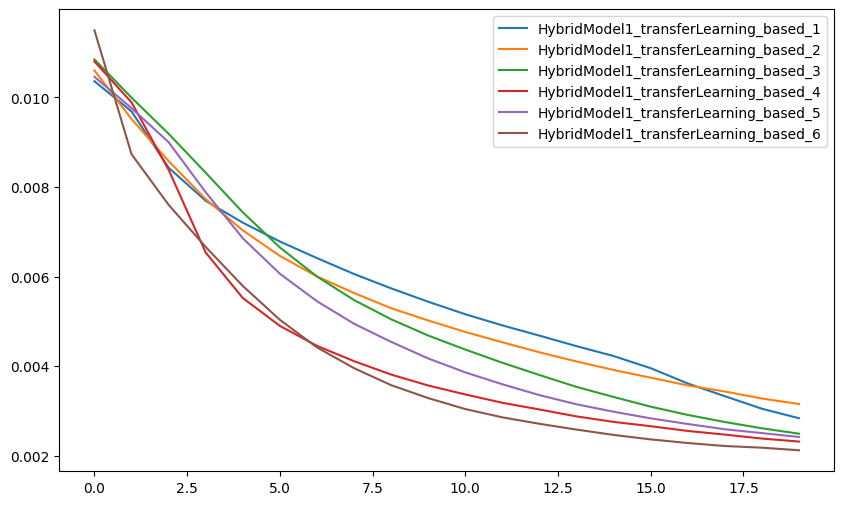

In [ ]:
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 6), dpi=100)
for model in results_dict.keys():
    plt.plot(results_dict[model]['loss'][:20], label = model)
plt.legend()
plt.show()

In [ ]:
model = models['HybridModel1_transferLearning_based_6']

In [ ]:
model = models['HybridModel1_transferLearning_based_5']

X_test_tensor = torch.Tensor(X_test).view(-1, 1, x_dim, y_dim)
y_test_tensor = torch.FloatTensor(y_test)  # Convert to FloatTensor for binary classification

# Create a DataLoader for the test set
test_loader = DataLoader(TensorDataset(X_test_tensor, y_test_tensor), batch_size=64)

print(test_acc(model, test_loader, device='cpu'))

0.9492753623188406


In [ ]:
for model in results_dict.keys():
    print(model)
    print(results_dict[model]["precision"])
    print(results_dict[model]["recall"])
    print(results_dict[model]["F1_score"])
    print("###########")

HybridModel1_transferLearning_based_1
0.9419942615434673
0.9429376018971395
0.9402103273071016
###########
HybridModel1_transferLearning_based_2
0.9586349688682336
0.9591136824525825
0.9588670556412493
###########
HybridModel1_transferLearning_based_3
0.9824120603015075
0.9801136363636364
0.9809036658141518
###########
HybridModel1_transferLearning_based_4
0.9852941176470589
0.9876847290640394
0.9863028994677485
###########
HybridModel1_transferLearning_based_5
0.9893048128342246
0.9891304347826086
0.9891000891000892
###########
HybridModel1_transferLearning_based_6
0.9950980392156863
0.9939393939393939
0.9944881653250031
###########
